Ein(g1): 0.24
alpha1: 0.5763397549691927
Ein(G): 0.0
U2: 0.8541662601625051
UT: 0.005465124119345903
the minimum value of epsilon_t: 0.1787280701754386
Eout(g1): 0.29
Eout(G): 0.127


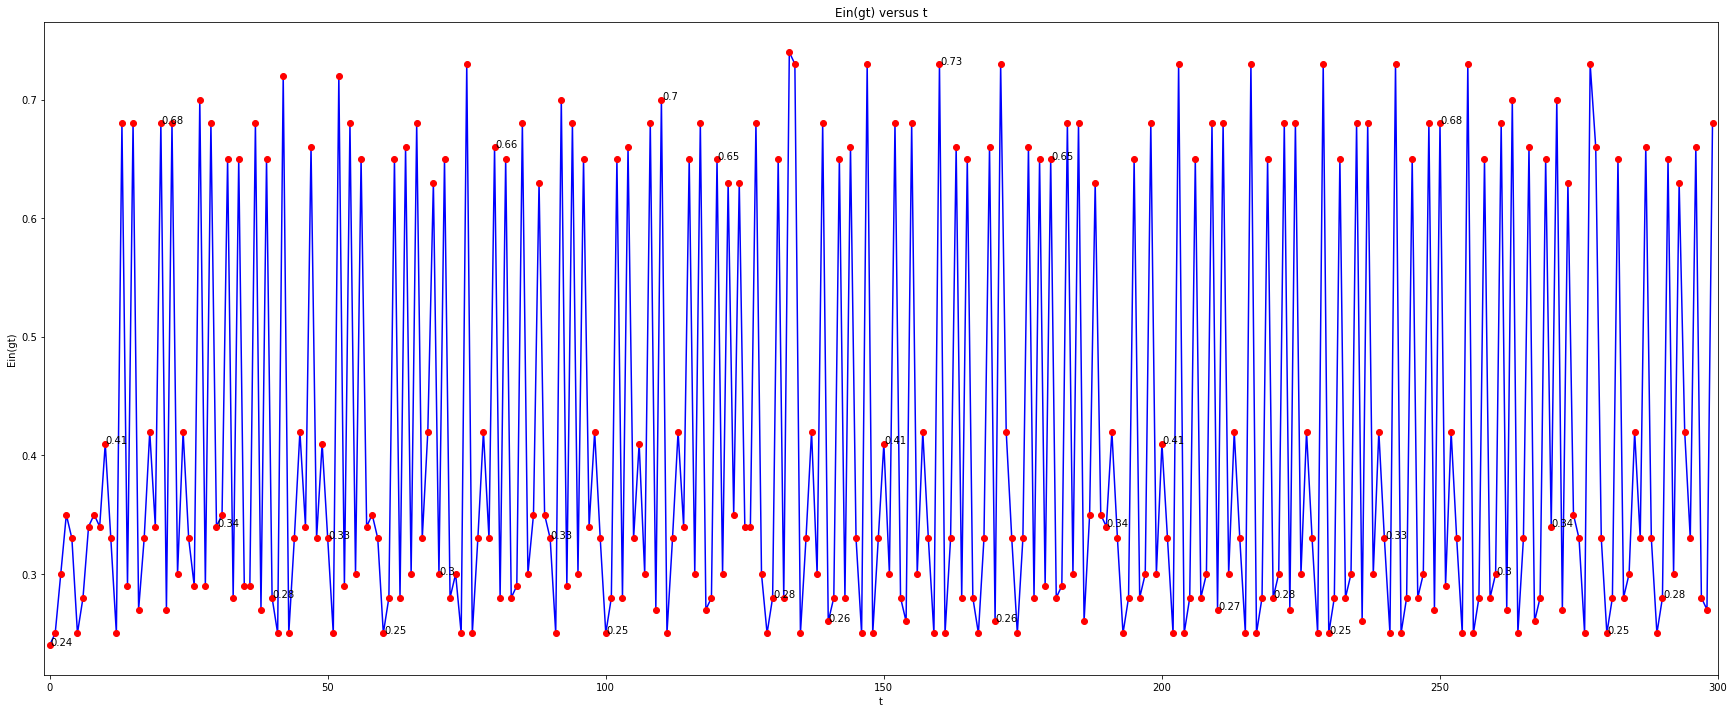

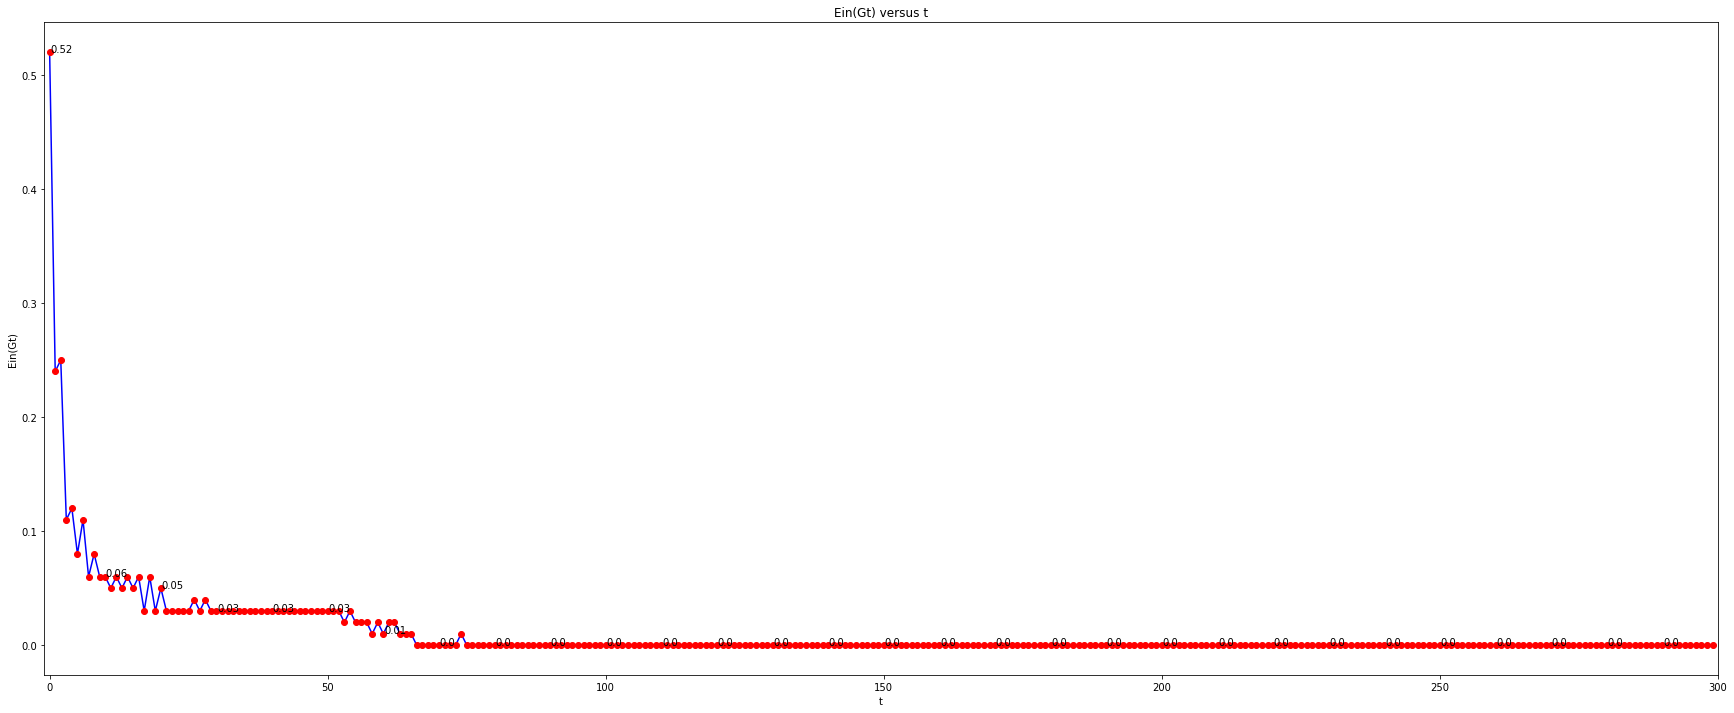

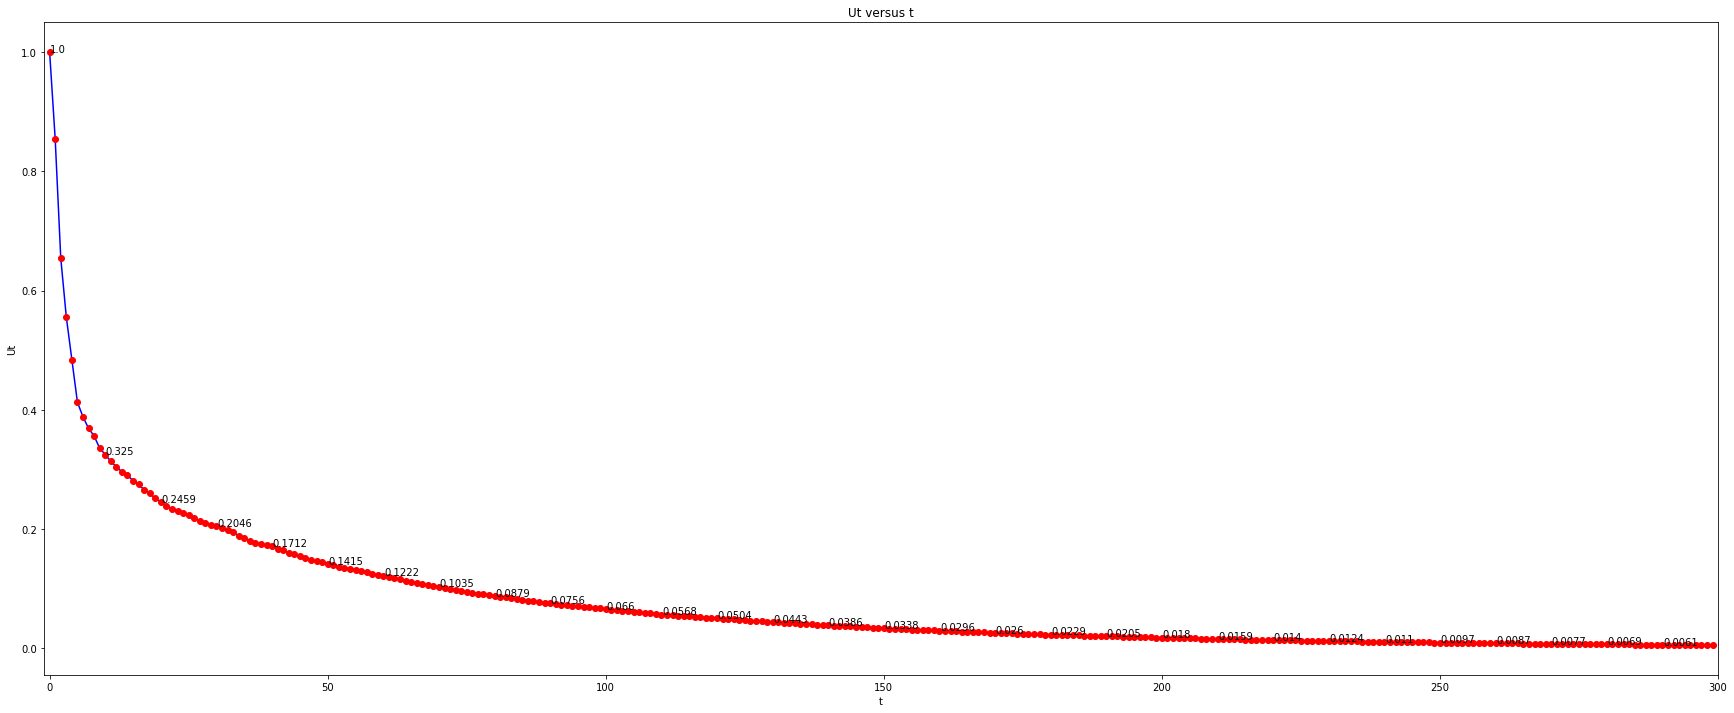

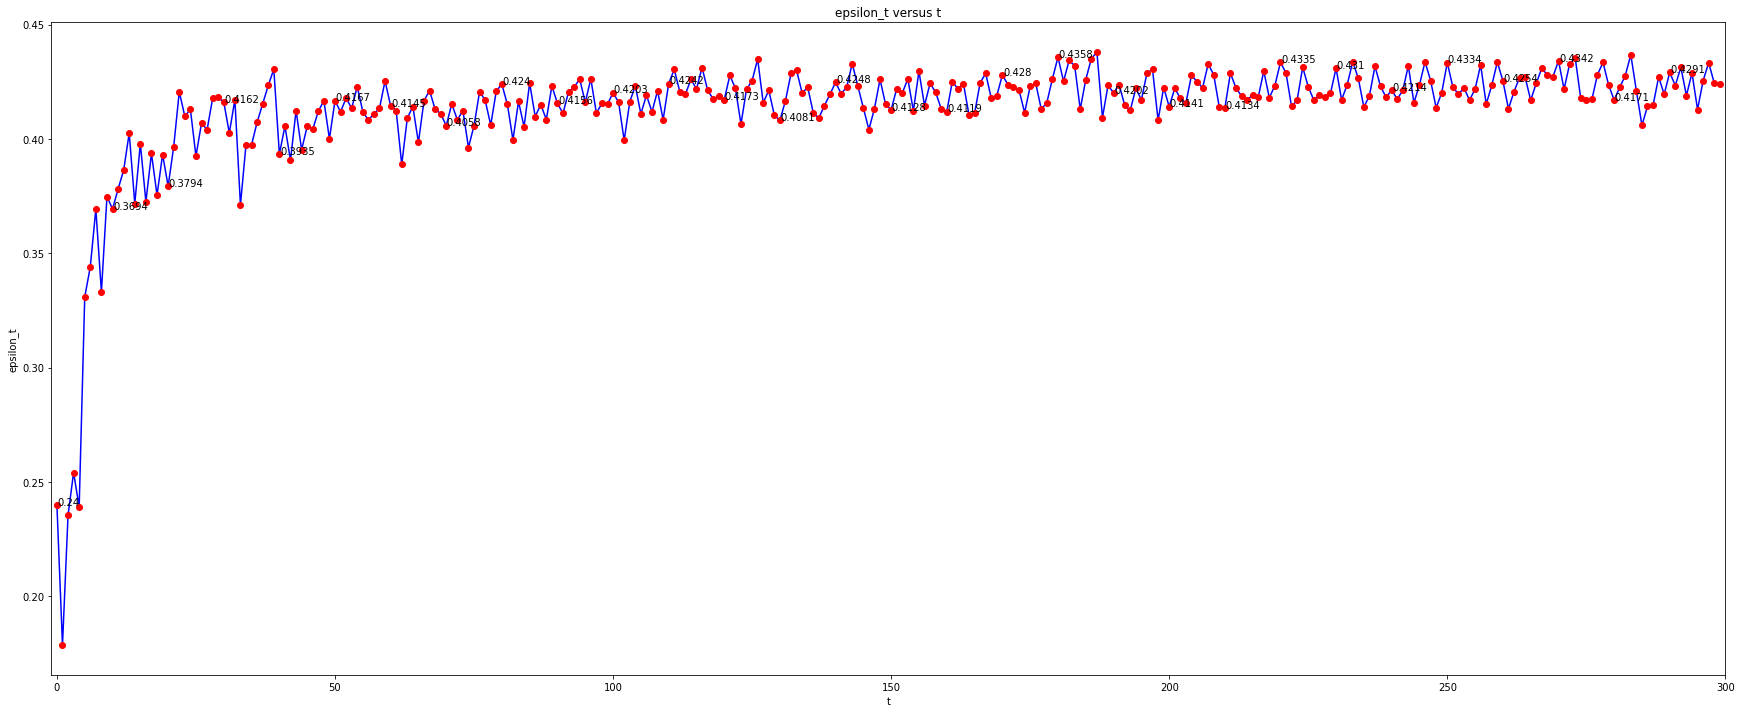

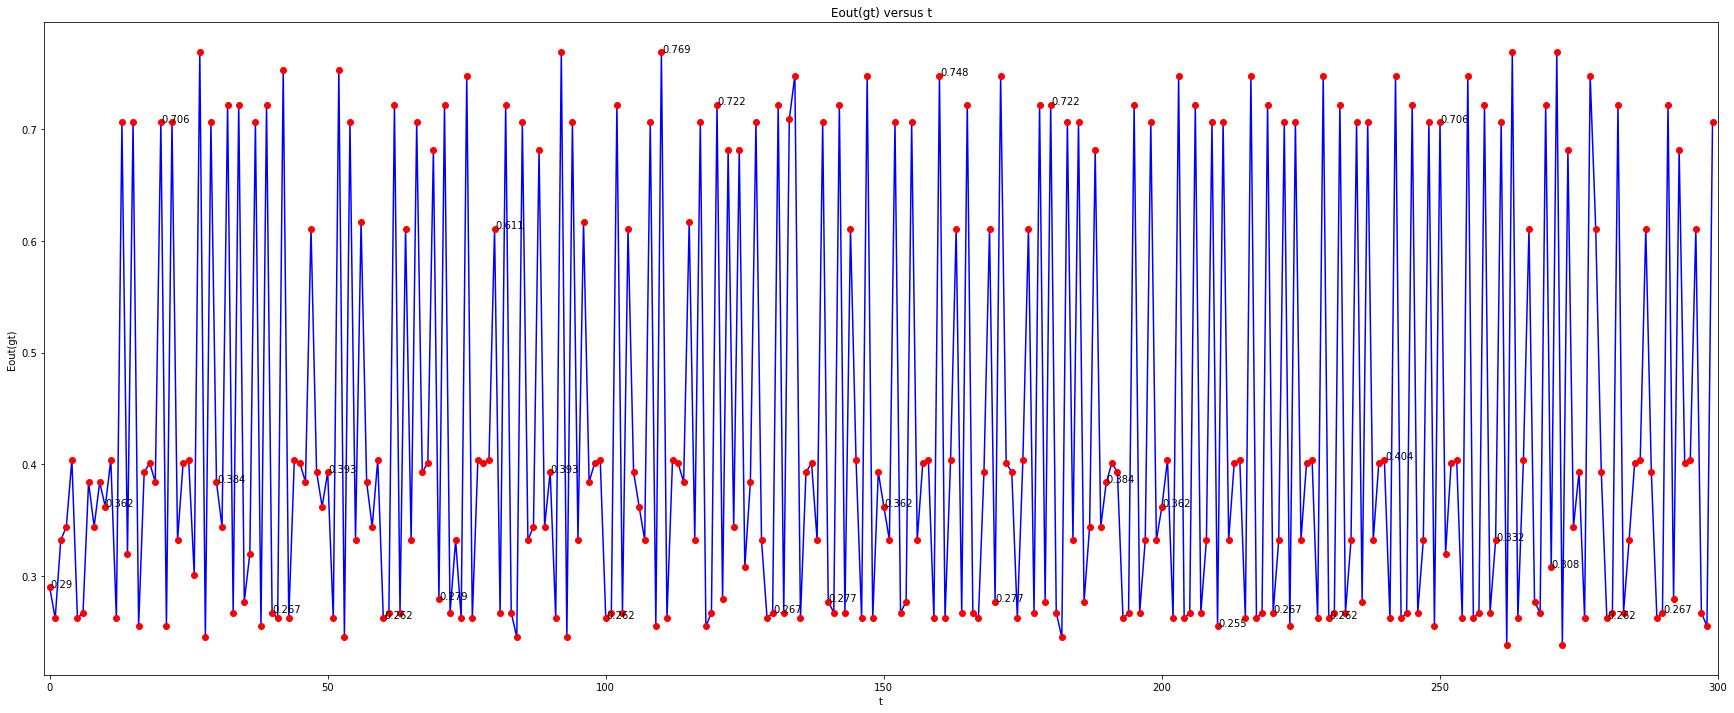

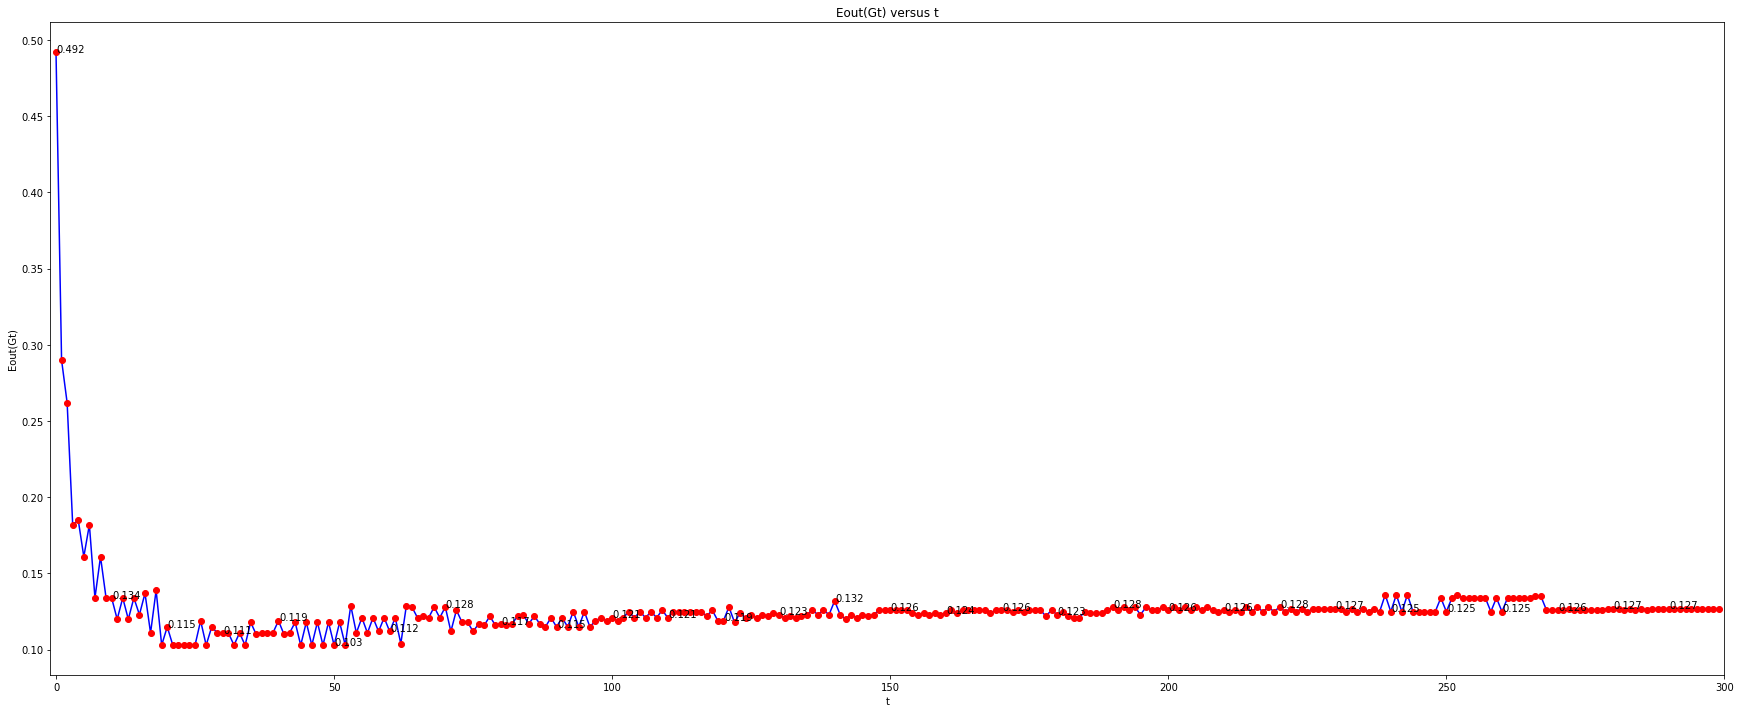

In [8]:
# coding:utf-8

import math
import numpy as np
import matplotlib.pyplot as plt


def ReadData(dataFile):

    with open(dataFile, 'r') as f:
        lines = f.readlines()
        data_list = []
        for line in lines:
            line = line.strip().split()
            data_list.append([float(l) for l in line])
        dataArray = np.array(data_list)
        return dataArray


def sign(n):

    if(n>=0):
        return 1
    else:
        return -1


def GetSortedArray(dataArray,i):
     # 根据dataArray第i列的值对dataArray进行从小到大的排序
    data_list=dataArray.tolist()
    sorted_data_list=sorted(data_list,key=lambda x:x[i],reverse=False)
    sortedDataArray=np.array(sorted_data_list)
    return sortedDataArray


def GetUZeroOneError(pred,dataY,u):
    return np.sum(u*np.not_equal(pred,dataY))/np.sum(u)


def GetZeroOneError(pred,dataY):
    return np.sum(np.not_equal(pred,dataY))/dataY.shape[0]


def decision_stump(dataArray,u):

    num_data=dataArray.shape[0]
    num_dim=dataArray.shape[1]-1
    min_e=np.inf
    min_s = np.inf
    min_d=np.inf
    min_theta = np.inf
    min_pred = np.zeros((num_data,))
    for d in range(num_dim):
        sortedDataArray=GetSortedArray(dataArray,d) # 确保有效theta
        d_min_e=np.inf
        d_min_s = np.inf
        d_min_theta = np.inf
        d_min_pred = np.zeros((num_data,))
        for s in [-1.0,1.0]:
            for i in range(num_data):
                if(i==0):
                    theta=-np.inf
                    pred=s*np.ones((num_data,))
                else:
                    if sortedDataArray[i-1,d]==sortedDataArray[i,d]:
                        continue
                    theta=(sortedDataArray[i-1,d]+sortedDataArray[i,d])/2
                    pred=np.zeros((num_data,))
                    for n in range(num_data):
                        pred[n]=s*sign(dataArray[n,d]-theta)
                d_now_e=GetUZeroOneError(pred,dataArray[:,-1],u)
                if(d_now_e<d_min_e):
                    d_min_e=d_now_e
                    d_min_s=s
                    d_min_theta=theta
                    d_min_pred=pred
        if(d_min_e<min_e):
            min_e=d_min_e
            min_s=d_min_s
            min_d=d
            min_theta=d_min_theta
            min_pred=d_min_pred
    return min_s,min_d,min_theta,min_pred,min_e


def Pred(paraList,dataX):
    # paraList=[s,d,theta]
    num_data=dataX.shape[0]
    pred=np.zeros((num_data,))
    for i in range(num_data):
        pred[i]=paraList[0]*sign(dataX[i,paraList[1]]-paraList[2])
    return pred


def plot_line_chart(X=np.arange(0,300,1).tolist(),Y=np.arange(0,300,1).tolist(),nameX="t",nameY="Ein(gt)",saveName="12.png"):

    plt.figure(figsize=(30,12))
    plt.plot(X,Y,'b')
    plt.plot(X,Y,'ro')
    plt.xlim((X[0]-1,X[-1]+1))
    for (x,y) in zip(X,Y):
        if(x%10==0):
            plt.text(x+0.1,y,str(round(y,4)))
    plt.xlabel(nameX)
    plt.ylabel(nameY)
    plt.title(nameY+" versus "+nameX)
    plt.savefig(saveName)
    return


if __name__=="__main__":

    dataArray=ReadData("hw2_adaboost_train.dat.txt")
    dataY=dataArray[:,-1]
    dataX=dataArray[:,:-1]
    num_data=dataArray.shape[0]
    u=np.full(shape=(num_data,),fill_value=1/num_data)
    ein_g_list=[]
    alpha_list=[]
    g_list=[]
    ein_G_list=[]
    u_sum_list=[]
    epi_list=[]
    min_pred_list=[]
    
    # adaboost
    for t in range(300):
        u_sum_list.append(np.sum(u))
        min_s,min_d,min_theta,min_pred,epi=decision_stump(dataArray,u)
        g_list.append([min_s,min_d,min_theta])
        min_pred_list.append(min_pred)
        ein_g=GetZeroOneError(min_pred,dataY)
        ein_g_list.append(ein_g)
        epi_list.append(epi)
        para=math.sqrt((1-epi)/epi)
        alpha_list.append(math.log(para))
        for i in range(num_data):
            if min_pred[i]==dataY[i]:
                u[i]/=para
            else:
                u[i]*=para
        predG=np.zeros((num_data,))
        for ta in range(t):
            predG+=alpha_list[ta]*min_pred_list[ta]
        for n in range(num_data):
            predG[n]=sign(predG[n])
        ein_G_list.append(GetZeroOneError(predG,dataY))

    # 12
    plot_line_chart(Y=ein_g_list)
    print("Ein(g1):",ein_g_list[0])
    print("alpha1:",alpha_list[0])

    # 14
    plot_line_chart(Y=ein_G_list,nameY="Ein(Gt)",saveName="14.png")
    print("Ein(G):",ein_G_list[-1])

    # 15
    plot_line_chart(Y=u_sum_list, nameY="Ut", saveName="15.png")
    print("U2:",u_sum_list[1])
    print("UT:",u_sum_list[-1])

    # 16
    plot_line_chart(Y=epi_list,nameY="epsilon_t",saveName="16.png")
    print("the minimum value of epsilon_t:",min(epi_list))

    testArray=ReadData("hw2_adaboost_test.dat.txt")
    num_test=testArray.shape[0]
    testX=testArray[:,:-1]
    testY=testArray[:,-1]
    pred_g_list=[]
    eout_g_list=[]
    eout_G_list=[]
    for t in range(300):
        pred_g=Pred(g_list[t],testX)
        pred_g_list.append(pred_g)
        eout_g_list.append(GetZeroOneError(pred_g,testY))
        pred_G=np.zeros((num_test,))
        for ta in range(t):
            pred_G+=alpha_list[ta]*pred_g_list[ta]
        sign_ufunc=np.frompyfunc(sign,1,1)
        pred_G=sign_ufunc(pred_G)
        eout_G_list.append(GetZeroOneError(pred_G,testY))

    # 17
    plot_line_chart(Y=eout_g_list, nameY="Eout(gt)", saveName="17.png")
    print("Eout(g1):",eout_g_list[0])

    # 18
    plot_line_chart(Y=eout_G_list, nameY="Eout(Gt)", saveName="18.png")
    print("Eout(G):",eout_G_list[-1])
